In [1]:
using Revise

In [81]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models
using DataFrames
using Blink
using RigidBodyDynamics

In [31]:
robot = BoxAtlas()
mvis = MechanismVisualizer(robot)
# IJuliaCell(mvis)
open(mvis, Blink.Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 9737`, ProcessRunning), TCPSocket(RawFD(61) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#3))), Blink.Page(1, WebSockets.WebSocket(5, TCPSocket(RawFD(55) active, 0 bytes waiting), CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#3)), Future(1, 1, 1, Nullable{Any}(true))))

In [32]:
@load "boxatlas.jld2" datasets net lqrsol mpc_params
mpc_params_data = mpc_params
mpc_params = MPCParams(robot)
mpc_params.Δt = mpc_params_data["Δt"]
mpc_params.horizon = mpc_params_data["horizon"]
net_cost = LearningMPC.LearnedCost(lqrsol, net)
net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);
full_mpc_controller = MPCController(robot, mpc_params, lqrsol, [lqrsol, net_mpc_controller]);
lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [38]:
x0 = nominal_state(robot)
x_init = nominal_state(robot)
set_velocity!(x0, findjoint(mechanism(robot), "floating_base"), [-3, 0, 0])
results = LCPSim.simulate(x0, net_mpc_controller, environment(robot), 0.01, 100, 
mpc_params.lcp_solver);

In [49]:
playback(mvis, results, 0.05)

In [51]:
environment(robot).contacts

4-element Array{Tuple{RigidBodyDynamics.RigidBody{Float64},RigidBodyDynamics.Spatial.Point3D{StaticArrays.SArray{Tuple{3},Float64,1,3}},LCPSim.Obstacle{Float64}},1}:
 (r_foot_sole, Point3D in "after_pelvis_to_r_foot_sole_extension": [0.0, 0.0, 0.0], LCPSim.Obstacle{Float64}(RigidBodyDynamics.Contact.HalfSpace3D{Float64}[RigidBodyDynamics.Contact.HalfSpace3D{Float64}(Point3D in "after_root_to_floor": [0.0, 0.0, 0.0], FreeVector3D in "after_root_to_floor": [0.0, 0.0, 1.0])], RigidBodyDynamics.Contact.HalfSpace3D{Float64}(Point3D in "after_root_to_floor": [0.0, 0.0, 0.0], FreeVector3D in "after_root_to_floor": [0.0, 0.0, 1.0]), 1.0, RigidBodyDynamics.Spatial.FreeVector3D{StaticArrays.SArray{Tuple{3},Float64,1,3}}[FreeVector3D in "after_root_to_floor": [0.0, -1.0, 6.12323e-17], FreeVector3D in "after_root_to_floor": [0.0, 1.0, 6.12323e-17]]))      
 (l_foot_sole, Point3D in "after_pelvis_to_l_foot_sole_extension": [0.0, 0.0, 0.0], LCPSim.Obstacle{Float64}(RigidBodyDynamics.Contact.HalfSpac

In [80]:
RigidBodyDynamics.dynamics(x0)

LoadError: [91mUndefVarError: dynamics not defined[39m

In [ ]:
net_direct_controller = let cache = StateCache(mechanism(robot))
    function (x)
        state = cache[eltype(configuration(x))]
        set_configuration!(state, configuration(x))
        set_velocity!(state, velocity(x))
        
        active_contacts = Iterators.filter(environment(robot).contacts) do c
            body, point, obstacle = c
            p = transform(state, point, obstacle.contact_face.point.frame)
            ϕ = LCPSim.separation(obstacle, p)
            ϕ < 1e-2
        end
        
#         @show [point for (b, point, obs) in active_contacts]
        u0 = LearningMPC.nominal_input(state, [point for (body, point, obs) in active_contacts])
#         @show u0
        
        B = ForwardDiff.jacobian(u0) do u
            diffstate = cache[eltype(u)]
            set_configuration!(diffstate, configuration(x))
            set_velocity!(diffstate, velocity(x))
            result = DynamicsResult{eltype(u)}(mechanism(robot))
            dynamics!(result, state, u)
            Vector(result)
        end
        @show B
    end
end
    

(::#91) (generic function with 1 method)

In [ ]:
net_direct_controller(x0)

In [ ]:
table = LearningMPC.run_evaluations(
    lqr_mpc_controller,
    "lqr_mpc",
    robot,
    lqrsol,
    [(1, [0])],
    [(1, linspace(-5, 5, 11)), (3, linspace(-10, 10, 11))];
)

append!(table, 
    LearningMPC.run_evaluations(
    net_mpc_controller,
    "net_mpc",
    robot,
    lqrsol,
    [(1, [0])],
    [(1, linspace(-5, 5, 11)), (3, linspace(-10, 10, 11))];
)
)

table

In [ ]:
jldopen("evaluation_table.jld2", "w") do file
    file["evaluations"] = table
end

In [1]:
using JLD2
using DataFrames
using Plots; gr()

Plots.GRBackend()

In [2]:
@load "evaluation_table.jld2" evaluations
table = evaluations;

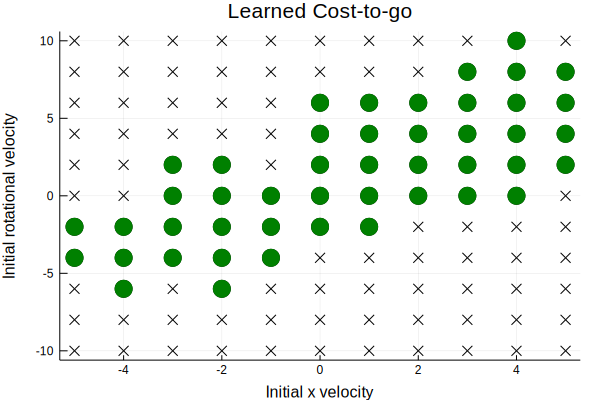

In [11]:
plt = plot(legend=false)
for row in eachrow(table)
    if row[:controller] == "net_mpc"
        success = -π/4 <= row[:qf][3] <= π/4
        if success
            scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = "green", marker = :dot, markersize = 10)
        else
            scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = "red", marker = :x)
        end
    end
end
title!(plt, "Learned Cost-to-go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "learned-cost-evaluation.svg")
plt

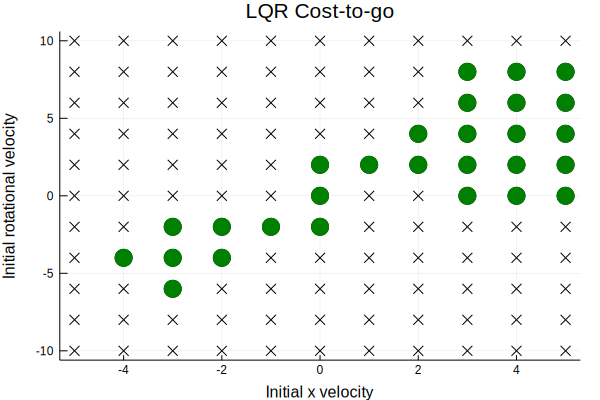

In [12]:
plt = plot(legend=false)
for row in eachrow(table)
    if row[:controller] == "lqr_mpc"
        success = -π/4 <= row[:qf][3] <= π/4
        if success
            scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = "green", marker = :dot, markersize = 10)
        else
            scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = "red", marker = :x)
        end
    end
end
title!(plt, "LQR Cost-to-go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "lqr-cost-evaluation.svg")
plt